# Coursera Python Applied Data Sciene Capstone Projekt 
## Peer-graded Assignment: Segmenting and Clustering Neighborhoods in Toronto

In this assignment, you will be required to explore, segment, and cluster the neighborhoods in the city of Toronto based on the postalcode and borough information.. However, unlike New York, the neighborhood data is not readily available on the internet. What is interesting about the field of data science is that each project can be challenging in its unique way, so you need to learn to be agile and refine the skill to learn new libraries and tools quickly depending on the project.

For the Toronto neighborhood data, a Wikipedia page exists that has all the information we need to explore and cluster the neighborhoods in Toronto. You will be required to scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas  dataframe so that it is in a structured format like the New York dataset.

Once the data is in a structured format, you can replicate the analysis that we did to the New York City dataset to explore and cluster the neighborhoods in the city of Toronto.

Your submission will be a link to your Jupyter Notebook on your Github repository.

## Imports

In [118]:
#webscrapping
import requests
from bs4 import BeautifulSoup

#data structuring and analytics
import pandas as pd
import numpy as np
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans

#coodrdinates
try:
    import geocoder
except:
    ! pip install geocoder
    import geocoder

#---Plotting---
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

try:
    import folium
except:
    ! pip install folium
    import folium

##  Scrap wikipedia webpage
Postal codes of Toronto/Canada. "M" reflects Toronto.

In [55]:
url = r'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

# request html
page = requests.get(url)

# parse html
soup = BeautifulSoup(page.content, "html.parser")


## Create dataframe from parsed html


 - create empty list
 - locate table
 - **remove records where borough is not specified** (critical assumption!)
 - append to empty 'cell' dict: Zipcode, borough, neighborhood
 - string-wrangling (split, replace...)
 - append final dict to list
 - transform to pandas df

In [54]:
#code copied from the scrapping hints 
# https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/NewLinkWebscrapingHints.md


table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned': #Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

df.sample(5)

,PostalCode,Borough,Neighborhood
85,M1V,Scarborough,"Milliken, Agincourt North, Steeles East, L'Amo..."
7,M3B,North York,Don Mills North
10,M6B,North York,Glencairn
84,M5T,Downtown Toronto,"Kensington Market, Chinatown, Grange Park"
20,M5E,Downtown Toronto,Berczy Park


In [4]:
df.shape
#there are 103 Boroughs in Toronto.

(103, 3)

### Calculate Geo-decimal coordinates from zipcodes

In [56]:
def transform_zip_to_geo_coords(zipcode):
    print('trying to retrieve coords for zip {}'.format(str(zipcode)))
    lat_lng_coords = None

    # loop until you get the coordinates
    while(lat_lng_coords is None):
      g = geocoder.google('{}, Toronto, Ontario'.format(str(zipcode)))
      lat_lng_coords = g.latlng

    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    print('coords received for zip {}'.format(str(zipcode)))
    return latitude, longitude

#transform_zip_to_geo_coords('M1V')

**As the geocoder API is extremely slow and practically not usable, the csv.file provided by coursera is used instead**

In [57]:
geo_data_url= r'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv'


!wget -q -O 'toronto_data.csv' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv

df_coords = pd.read_csv(r'toronto_data.csv')

#### Merge Borough-data with coordinates-data

In [58]:
df_merged = pd.merge(df, df_coords, how='left', left_on='PostalCode', right_on='Postal Code').drop(columns='Postal Code')
df_merged.sample(5)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
59,M2N,North York,Willowdale South,43.770120,-79.408493
35,M4J,East York/East Toronto,The Danforth East,43.685347,-79.338106
96,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675
43,M6K,West Toronto,"Brockton, Parkdale Village, Exhibition Place",43.636847,-79.428191
19,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [59]:
df_merged.shape
#2 columna are added (lat, lon)
# number of rows unchanged

(103, 5)

## Display on map
The coordinates associated with the boroughs of Toronto are displayed as blue circles.

In [60]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[df_merged['Latitude'].mean(), df_merged['Longitude'].mean()], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Borough'], df_merged['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## Foursquare API Requests
Download data from foursquare.

#### Credentials (hidden)

In [172]:
%%capture
CLIENT_ID = 'AGWRGMN2ALSHRRLER5MMRQUXOKY3PI4CJMRJC20FUWHENKP0' # your Foursquare ID
CLIENT_SECRET = '1OJYDLOCMFZ5X1PMQYUKUETJXIDKFVHDBFN5Y2OCSR52ZPS5' # your Foursquare Secret
ACCESS_TOKEN = 'PLY4LHDROXOHU2T3HH1G2JOY4MKFKQYAPMJNVGOBWGZ13VE2' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version

In [173]:
LIMIT = 100 # limit of number of venues returned by Foursquare API # A default Foursquare API limit value
radius = 500

def get_foursquare_url(lat, lon, limit=5, radius=200):
    """
    Generaters foursquare API-request in terms of a URL including the query parameters.
    
    Returns API-URL
    
    Parameters:
        - Credentials
        - lat: latitude (float)
        - lon: longitude (float)
        - radius: search radius in m (float)
        - LIMIT: limit number of returned results
    """
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
       lat, 
        lon,
        radius, 
        LIMIT)
    print(url)
    return url




#### Perform Foursquare-API query 
Result is stored in json

In [135]:
results = requests.get(
    get_foursquare_url(df_merged['Latitude'].mean(),  df_merged['Longitude'].mean(), limit=200, radius=600)
).json()

https://api.foursquare.com/v2/venues/explore?&client_id=AGWRGMN2ALSHRRLER5MMRQUXOKY3PI4CJMRJC20FUWHENKP0&client_secret=1OJYDLOCMFZ5X1PMQYUKUETJXIDKFVHDBFN5Y2OCSR52ZPS5&v=20180605&ll=43.704607733980595,-79.3971529116505&radius=600&limit=100


In [136]:

def get_category_type(row):
    """
    extracts category of a venue
    """
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [137]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

print('{} venues found'.format(len(nearby_venues)))
nearby_venues.sample(10)

78 venues found


/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng
77,Redpath Convenience,Grocery Store,43.708482,-79.393180
56,Tim Hortons,Coffee Shop,43.707264,-79.399511
41,Boom Breakfast & Co.,Breakfast Spot,43.705748,-79.403482
39,Sip Wine Bar,Wine Bar,43.709707,-79.398558
48,Sushi Supreme,Sushi Restaurant,43.700563,-79.397118
0,The Keg Steakhouse + Bar - Yonge + Eglinton,Restaurant,43.705702,-79.397905
33,Ritz Caribbean Food,Caribbean Restaurant,43.706486,-79.399763
58,Shoppers Drug Mart,Pharmacy,43.708887,-79.398060
64,Quick Pita,Middle Eastern Restaurant,43.707959,-79.392612
14,La Salumeria,Deli / Bodega,43.701255,-79.397117


In [138]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = get_foursquare_url(lat, lon, limit=200, radius=600)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [139]:
#get venues for each coordinate in list of Toronto's Boroughs
toronto_venues = getNearbyVenues(names=df_merged['Neighborhood'],
                                   latitudes=df_merged['Latitude'],
                                   longitudes=df_merged['Longitude']
                                  )

https://api.foursquare.com/v2/venues/explore?&client_id=AGWRGMN2ALSHRRLER5MMRQUXOKY3PI4CJMRJC20FUWHENKP0&client_secret=1OJYDLOCMFZ5X1PMQYUKUETJXIDKFVHDBFN5Y2OCSR52ZPS5&v=20180605&ll=43.7532586,-79.52099940000001&radius=600&limit=100
https://api.foursquare.com/v2/venues/explore?&client_id=AGWRGMN2ALSHRRLER5MMRQUXOKY3PI4CJMRJC20FUWHENKP0&client_secret=1OJYDLOCMFZ5X1PMQYUKUETJXIDKFVHDBFN5Y2OCSR52ZPS5&v=20180605&ll=43.725882299999995,-79.52099940000001&radius=600&limit=100
https://api.foursquare.com/v2/venues/explore?&client_id=AGWRGMN2ALSHRRLER5MMRQUXOKY3PI4CJMRJC20FUWHENKP0&client_secret=1OJYDLOCMFZ5X1PMQYUKUETJXIDKFVHDBFN5Y2OCSR52ZPS5&v=20180605&ll=43.6542599,-79.52099940000001&radius=600&limit=100
https://api.foursquare.com/v2/venues/explore?&client_id=AGWRGMN2ALSHRRLER5MMRQUXOKY3PI4CJMRJC20FUWHENKP0&client_secret=1OJYDLOCMFZ5X1PMQYUKUETJXIDKFVHDBFN5Y2OCSR52ZPS5&v=20180605&ll=43.718517999999996,-79.52099940000001&radius=600&limit=100
https://api.foursquare.com/v2/venues/explore?&client

In [140]:
toronto_venues.sample(5)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
169,Woburn,43.770992,-79.216917,Black Creek Pioneer Village,43.773393,-79.516991,Historic Site
578,"Dorset Park, Wexford Heights, Scarborough Town...",43.757410,-79.273304,Petro-Canada,43.757187,-79.517778,Gas Station
524,Studio District,43.659526,-79.340923,Second Cup Coffee Co.,43.662152,-79.519383,Café
78,"Garden District, Ryerson",43.657162,-79.378937,Baskin-Robbins,43.661654,-79.519190,Ice Cream Shop
735,"University of Toronto, Harbord",43.662696,-79.400049,Humbertown Convenience,43.664929,-79.520481,Convenience Store


In [141]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))
toronto_venues.groupby('Neighborhood').count()

There are 93 uniques categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,6,6,6,6,6,6
"Alderwood, Long Branch",11,11,11,11,11,11
"Bathurst Manor, Wilson Heights, Downsview North",23,23,23,23,23,23
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",2,2,2,2,2,2
...,...,...,...,...,...,...
"Willowdale, Newtonbrook",2,2,2,2,2,2
Woburn,10,10,10,10,10,10
Woodbine Heights,4,4,4,4,4,4


### Binary encoding

In [142]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

#group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()


#toronto_grouped.sample(5)



### Calculate frequencies of most popular venue-types

In [146]:
num_top_venues = 10

for hood in toronto_grouped['Neighborhood']:
    #print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    #print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    #print('\n')

In [147]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [149]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.sample(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
79,"Steeles West, L'Amoreaux West",Other Nightlife,Furniture / Home Store,Zoo,Food & Drink Shop,Donut Shop,Eastern European Restaurant,Electronics Store,Fabric Shop,Falafel Restaurant,Fast Food Restaurant
98,"Willowdale, Newtonbrook",Italian Restaurant,Shopping Mall,Zoo,Flower Shop,Discount Store,Donut Shop,Eastern European Restaurant,Electronics Store,Fabric Shop,Falafel Restaurant
0,Agincourt,Other Nightlife,Sandwich Place,Intersection,Italian Restaurant,Bus Station,Metro Station,Zoo,Flower Shop,Eastern European Restaurant,Electronics Store
97,Willowdale West,Hardware Store,Metro Station,Bus Station,Food & Drink Shop,Donut Shop,Eastern European Restaurant,Electronics Store,Fabric Shop,Falafel Restaurant,Fast Food Restaurant
31,Enclave of M5E,Coffee Shop,Pub,Thai Restaurant,Fast Food Restaurant,Pizza Place,Bus Stop,Indian Restaurant,Caribbean Restaurant,Restaurant,Sandwich Place


In [150]:
neighborhoods_venues_sorted.shape

(103, 11)

## Clustering

In [151]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 2, 0, 1, 0, 0, 0], dtype=int32)

In [152]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_merged

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_grouped.sample(5) # check the last columns!

,Neighborhood,American Restaurant,Arts & Crafts Store,Athletics & Sports,Bakery,Bank,Beer Store,Breakfast Spot,Brewery,Burger Joint,...,Sushi Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Thrift / Vintage Store,Toy / Game Store,Vietnamese Restaurant,Wings Joint,Yoga Studio,Zoo
56,"Milliken, Agincourt North, Steeles East, L'Amo...",0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
31,Enclave of M5E,0.0,0.034483,0.0,0.034483,0.000000,0.034483,0.0,0.0,0.0,...,0.0,0.0,0.0,0.068966,0.0,0.0,0.0,0.0,0.0,0.0
89,"University of Toronto, Harbord",0.0,0.000000,0.0,0.066667,0.066667,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
100,Woodbine Heights,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
20,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",0.0,0.000000,0.0,0.250000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [153]:


# create map
map_clusters = folium.Map(location=[df_merged['Latitude'].mean(), df_merged['Longitude'].mean()], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels'].fillna(1)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Cluster Analysis

In [154]:

def get_cluster_data(cluster_index=0):
    return toronto_merged.loc[toronto_merged['Cluster Labels'] == cluster_index, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

In [155]:
cluster_len_ststs = pd.DataFrame([[i,len(get_cluster_data(i))] for i in toronto_merged['Cluster Labels'].unique()],columns=['Cluster','Members'])

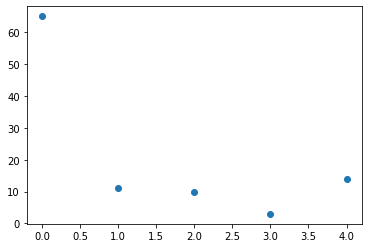

In [156]:
plt.scatter(cluster_len_ststs['Cluster'],cluster_len_ststs['Members'])
plt.show()

In [158]:
cluster_len_ststs.sort_values(by='Cluster')

,Cluster,Members
0,0,65
3,1,11
2,2,10
4,3,3
1,4,14


Cluster 0

In [159]:
get_cluster_data(cluster_index=0)

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,0,Coffee Shop,Grocery Store,Pizza Place,Discount Store,Caribbean Restaurant,Sandwich Place,Shopping Mall,Fast Food Restaurant,Plaza,Intersection
1,North York,0,Department Store,Discount Store,Donut Shop,Golf Course,Food & Drink Shop,Eastern European Restaurant,Electronics Store,Fabric Shop,Falafel Restaurant,Fast Food Restaurant
4,Queen's Park,0,Grocery Store,Restaurant,Shopping Mall,Skating Rink,Camera Store,Spa,Ice Cream Shop,Supermarket,Japanese Restaurant,Convenience Store
7,North York,0,Food & Drink Shop,Home Service,Park,Tea Room,Fabric Shop,Zoo,Donut Shop,Eastern European Restaurant,Electronics Store,Falafel Restaurant
9,Downtown Toronto,0,Gourmet Shop,Supermarket,Pharmacy,Grocery Store,Liquor Store,Restaurant,Camera Store,Café,Spa,Italian Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...
97,Downtown Toronto,0,Coffee Shop,Pub,Grocery Store,Fast Food Restaurant,Thai Restaurant,Sandwich Place,Gym,Indian Restaurant,Japanese Restaurant,Metro Station
99,Downtown Toronto,0,Japanese Restaurant,Grocery Store,Skating Rink,Camera Store,Spa,Liquor Store,Ice Cream Shop,Restaurant,Convenience Store,Pharmacy
100,East Toronto Business,0,Grocery Store,Restaurant,Shopping Mall,Skating Rink,Camera Store,Spa,Ice Cream Shop,Supermarket,Japanese Restaurant,Convenience Store
101,Etobicoke,0,Gym / Fitness Center,Deli / Bodega,Burger Joint,Pizza Place,Grocery Store,Coffee Shop,Restaurant,Sandwich Place,Café,Italian Restaurant


Cluster 1

In [160]:
get_cluster_data(cluster_index=1)

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Etobicoke,1,Park,Bakery,Convenience Store,Skating Rink,Zoo,Flower Shop,Donut Shop,Eastern European Restaurant,Electronics Store,Fabric Shop
10,North York,1,Park,Convenience Store,Outdoors & Recreation,Zoo,Diner,Donut Shop,Eastern European Restaurant,Electronics Store,Fabric Shop,Falafel Restaurant
14,East York,1,Park,Gas Station,Skating Rink,Soccer Field,Zoo,Fish & Chips Shop,Discount Store,Donut Shop,Eastern European Restaurant,Electronics Store
16,York,1,Park,Gas Station,Skating Rink,Zoo,Fish & Chips Shop,Discount Store,Donut Shop,Eastern European Restaurant,Electronics Store,Fabric Shop
23,East York,1,Park,Zoo,Food & Drink Shop,Donut Shop,Eastern European Restaurant,Electronics Store,Fabric Shop,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop
25,Downtown Toronto,1,Bakery,Convenience Store,Park,Fast Food Restaurant,Zoo,Food & Drink Shop,Eastern European Restaurant,Electronics Store,Fabric Shop,Falafel Restaurant
31,West Toronto,1,Park,Bakery,Convenience Store,Skating Rink,Zoo,Flower Shop,Donut Shop,Eastern European Restaurant,Electronics Store,Fabric Shop
44,Scarborough,1,Park,Sports Club,Convenience Store,Outdoors & Recreation,Furniture / Home Store,Flower Shop,Donut Shop,Eastern European Restaurant,Electronics Store,Fabric Shop
47,East Toronto,1,Park,Bakery,Convenience Store,Skating Rink,Zoo,Flower Shop,Donut Shop,Eastern European Restaurant,Electronics Store,Fabric Shop
58,Scarborough,1,Pizza Place,Park,Gas Station,Zoo,Flower Shop,Donut Shop,Eastern European Restaurant,Electronics Store,Fabric Shop,Falafel Restaurant


Cluster 2

In [161]:
get_cluster_data(cluster_index=2)

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,North York,2,Furniture / Home Store,Spa,Coffee Shop,Outdoors & Recreation,Intersection,Zoo,Donut Shop,Eastern European Restaurant,Electronics Store,Fabric Shop
6,Scarborough,2,Print Shop,Gym,Gas Station,Furniture / Home Store,Zoo,Fish & Chips Shop,Discount Store,Donut Shop,Eastern European Restaurant,Electronics Store
27,North York,2,Home Service,Print Shop,Furniture / Home Store,Zoo,Flower Shop,Discount Store,Donut Shop,Eastern European Restaurant,Electronics Store,Fabric Shop
49,North York,2,Furniture / Home Store,Intersection,Outdoors & Recreation,Zoo,Flower Shop,Donut Shop,Eastern European Restaurant,Electronics Store,Fabric Shop,Falafel Restaurant
51,Scarborough,2,Furniture / Home Store,Coffee Shop,Intersection,Outdoors & Recreation,Zoo,Flower Shop,Donut Shop,Eastern European Restaurant,Electronics Store,Fabric Shop
55,North York,2,Pool,Furniture / Home Store,Food & Drink Shop,Discount Store,Donut Shop,Eastern European Restaurant,Electronics Store,Fabric Shop,Falafel Restaurant,Fast Food Restaurant
62,Central Toronto,2,Sports Club,Convenience Store,Park,Outdoors & Recreation,Intersection,Furniture / Home Store,Fish & Chips Shop,Donut Shop,Eastern European Restaurant,Electronics Store
67,Central Toronto,2,Furniture / Home Store,Intersection,Outdoors & Recreation,Zoo,Flower Shop,Donut Shop,Eastern European Restaurant,Electronics Store,Fabric Shop,Falafel Restaurant
73,Central Toronto,2,Furniture / Home Store,Coffee Shop,Intersection,Outdoors & Recreation,Zoo,Flower Shop,Donut Shop,Eastern European Restaurant,Electronics Store,Fabric Shop
90,Scarborough,2,Other Nightlife,Furniture / Home Store,Zoo,Food & Drink Shop,Donut Shop,Eastern European Restaurant,Electronics Store,Fabric Shop,Falafel Restaurant,Fast Food Restaurant


Cluster 3

In [162]:
get_cluster_data(cluster_index=3)

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,East Toronto,3,Playground,Bus Line,Food & Drink Shop,Discount Store,Donut Shop,Eastern European Restaurant,Electronics Store,Fabric Shop,Falafel Restaurant,Fast Food Restaurant
41,East Toronto,3,Playground,Bus Line,Food & Drink Shop,Discount Store,Donut Shop,Eastern European Restaurant,Electronics Store,Fabric Shop,Falafel Restaurant,Fast Food Restaurant
91,Downtown Toronto,3,Playground,Bus Line,Food & Drink Shop,Discount Store,Donut Shop,Eastern European Restaurant,Electronics Store,Fabric Shop,Falafel Restaurant,Fast Food Restaurant


Cluster 4

In [163]:
get_cluster_data(cluster_index=4)

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,4,Italian Restaurant,History Museum,Park,Food & Drink Shop,Donut Shop,Eastern European Restaurant,Electronics Store,Fabric Shop,Falafel Restaurant,Fast Food Restaurant
8,East York,4,Grocery Store,Deli / Bodega,Pharmacy,Park,Zoo,Fish & Chips Shop,Donut Shop,Eastern European Restaurant,Electronics Store,Fabric Shop
11,Etobicoke,4,Grocery Store,History Museum,Bank,Park,Coffee Shop,Italian Restaurant,Flower Shop,Eastern European Restaurant,Electronics Store,Fabric Shop
15,Downtown Toronto,4,History Museum,Grocery Store,Bank,Park,Coffee Shop,Italian Restaurant,Flower Shop,Eastern European Restaurant,Electronics Store,Fabric Shop
29,East York,4,Grocery Store,Pharmacy,Park,Fried Chicken Joint,Diner,Zoo,Fish & Chips Shop,Donut Shop,Eastern European Restaurant,Electronics Store
63,York,4,Park,Fast Food Restaurant,Bus Line,Zoo,Food & Drink Shop,Donut Shop,Eastern European Restaurant,Electronics Store,Fabric Shop,Falafel Restaurant
64,York,4,Park,Deli / Bodega,Thai Restaurant,Fish & Chips Shop,Zoo,Flower Shop,Donut Shop,Eastern European Restaurant,Electronics Store,Fabric Shop
68,Central Toronto,4,Park,Pharmacy,Diner,Gas Station,Fried Chicken Joint,Skating Rink,Pizza Place,Soccer Field,Falafel Restaurant,Discount Store
74,Central Toronto,4,Park,Fast Food Restaurant,Bus Line,Zoo,Food & Drink Shop,Donut Shop,Eastern European Restaurant,Electronics Store,Fabric Shop,Falafel Restaurant
79,Central Toronto,4,Diner,Pizza Place,Grocery Store,Pharmacy,Park,Fried Chicken Joint,Fish & Chips Shop,Donut Shop,Eastern European Restaurant,Electronics Store
